# Estimate deadtime by using data taken in the surface

#### Created by Jorge Torres, 6/16/2023

### Import needed libraries

In [ ]:
import ROOT

import sys
import math

import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

In [ ]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=14)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['ytick.major.size'] = 8

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.linewidth'] = 1.2 # set the value globally

# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=22)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

### Import parser that Tom wrote. This is containted in the file named $\texttt{dt5202.py}$ in this folder

In [ ]:
from dt5202 import dt5202_crunch

from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ
ped = 100 #pedestal correction

In [ ]:
#Import data files
#sourceFolder = "/data/20220826_AND48hrs#/"
sourceFolder = "/data/board1771_01192023_retestingSwirlyPanel/"
#folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory
onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
print(onlyfiles)
data_list = []
for file in onlyfiles:
    
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]

for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

#f = sourceFolder+'Run0_list.dat'
#data = dt5202_crunch(f, num_ev=10000000, num_ch=2)

In [ ]:
print (data[0])
print (data[1])
#print (data[2])
#print (data[3])

#print (data[4])
#print (data[64])


# print (data['data']['low_gain'][:,0])
# print (data['data']['high_gain'][0])
# print (data['data']['low_gain'][3])
# print (data['data']['high_gain'][3])
# print (data['data']['low_gain'][5])
# print (data['data']['high_gain'][5])
#print (data['channel_id']['data']['high_gain'][0])

In [ ]:
data.shape

In [ ]:
#plotting High Gain Data to View SPE peaks
plt.hist(data['data']['low_gain'], bins=100, range=(10,7550),
         histtype='step');
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
plt.yscale('log')

plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts: Prototype Panel')
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist_HighGainBigPanel.png')

## Now we can calculate the P.E./MeV by using the muon distribution from low gain data

#### A few technical details here: the Landau-Gaus fitting has to be done in ROOT, so I'll use ROOT here to do that. I'm first converting the numpy arrays into a TH1D object and then fitting.

In [13]:
from root_numpy import array2hist, hist2array, fill_hist
c1 = TCanvas( 'c1', 'Dynamic Filling Example', 200, 10, 700, 500 )
hpx = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, 10 min run', 200, 0, 7500)
#fill_hist(hpx, np.array(data['data']['low_gain'][:,1]))
fill_hist(hpx, np.array(data['data']['low_gain']))

/home/coure/Software/DataTakingVenv/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: Gaussian-convoluted Landau (Potential memory leak).


/home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
/home/coure/Iris_DT5202Analzer/dt5202_analysis
 FCN=109.357 FROM MIGRAD    STATUS=CONVERGED     566 CALLS         567 TOTAL
                     EDM=2.576e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.1 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   3.57330e+02   5.09365e+00   2.01057e-02  -9.86700e-06
   2  LandauMPV    2.66683e+03   8.31397e+00  -7.02095e-03   1.38623e-05
   3  Normalisation   7.47080e+04   1.46228e+03   2.02681e+00   6.36887e-07
   4  GaussianSigma   4.30213e+00   1.01856e-01  -4.38817e-04   2.27586e-03
                               ERR DEF= 0.5


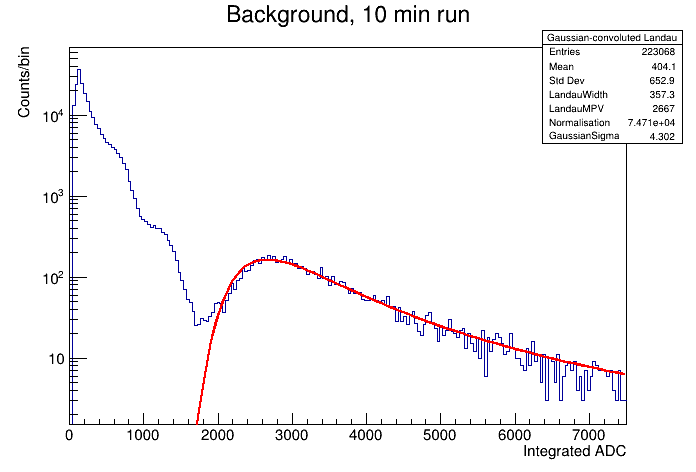

In [14]:
# Maybe it would be less confusing to include langaus in the same directory? I had trouble with this function because the file was not in the correct directory.
%cd /home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
from langaus import LanGausFit
%cd - 

hpx.Draw()
gPad.SetLogy();
gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(hpx, fitrange=(1900,8000))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
hpx.GetXaxis().SetTitle("Integrated ADC");
hpx.GetYaxis().SetTitle("Counts/bin");

hpx.Draw()
func.Draw("same")
tf1 = ROOT.TF1("landaugausfunction", ROOT.langaufun, 0, 8000, 4)
tf1.SetParNames("LandauWidth","LandauMPV","Normalisation","GaussianSigma")
tf1.SetParameters(func.GetParameter(0), func.GetParameter(1), func.GetParameter(2), func.GetParameter(3))
tf1.Draw("same")

c1.Draw()
# c1.SaveAs("Fitted_noCoincidences_swirlyTry2.pdf");


In [15]:
func.GetChisquare()/func.GetNDF()

1.8057929416144942

Unknown function: expo+gaus(1)


/home/coure/Software/DataTakingVenv/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ctest
Warning in <TROOT::Append>: Replacing existing TH1: Gaussian-convoluted Landau (Potential memory leak).


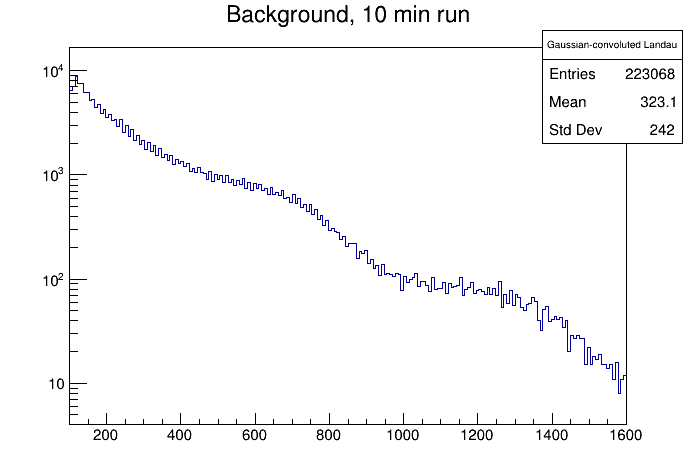

In [40]:
from root_numpy import array2hist, hist2array, fill_hist
ctest = TCanvas( 'ctest', 'Dynamic Filling Example', 200, 10, 700, 500 )
hpx_test = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, 10 min run', 200, 100, 1600)
fill_hist(hpx_test, np.array(data['data']['low_gain']))
hpx_test.Draw()
gPad.SetLogy();
gStyle.SetOptFit(2)
hpx_test.Fit("expo+gaus(4)", "", "", 110, 500)
# The fitter return a ROOT TF1 (a 1D function).
# func.Draw("same")


ctest.Draw()
# c1.SaveAs("Fitted_noCoincidences_swirlyTry2.pdf");


In [25]:
MPV = func.GetParameter(1) #This corresponds to the most probable value (MPV) of the distr.
print(MPV)

2666.830212601258


 FCN=133.328 FROM MIGRAD    STATUS=CONVERGED     116 CALLS         117 TOTAL
                     EDM=2.06051e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.45441e+03   8.58548e+01   1.47488e-01   2.04270e-06
   2  Mean         3.79153e+02   9.81580e+00   7.47599e-03   3.50924e-05
   3  Sigma        2.72286e+02   4.58934e+00   8.98096e-06   2.73842e-02
 FCN=87.4172 FROM MIGRAD    STATUS=CONVERGED     107 CALLS         108 TOTAL
                     EDM=4.29714e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.78594e+02   1.77047e+01   3.21284e-02  -7.71944e-06
   2  Mean         1.00902e+03   2.72392e+01   1.99999e-02  -1.99008e-05
   3  Sigma        2.95875e+02   

/home/coure/Software/DataTakingVenv/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TROOT::Append>: Replacing existing TH1: Gaussian-convoluted Landau (Potential memory leak).
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.


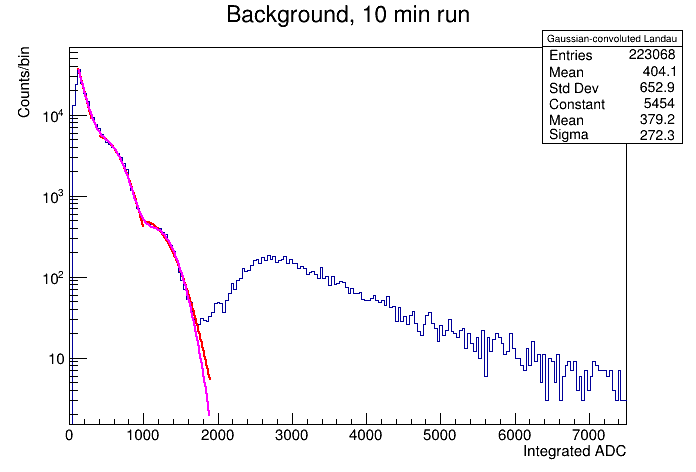

In [50]:
from array import array

c2 = TCanvas( 'c2', 'Dynamic Filling Example', 200, 10, 700, 500 )
hpx2 = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, 10 min run', 200, 0, 7500)
#fill_hist(hpx, np.array(data['data']['low_gain'][:,1]))
fill_hist(hpx2, np.array(data['data']['low_gain']))

hpx2.Draw()
gPad.SetLogy();
gStyle.SetOptFit(2)
# fit = LanGausFit()
# func = fit.fit(hpx, fitrange=(0,4000))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
hpx2.GetXaxis().SetTitle("Integrated ADC");
hpx2.GetYaxis().SetTitle("Counts/bin");

hpx2.Draw()

par = array( 'd', 9*[0.] )
g1 = TF1( 'g1', 'gaus',  400,  1000 )
g2 = TF1( 'g2', 'gaus',  1000, 1900 )
g3 = TF1( 'g3', 'gaus', 120, 300 )
# e1 = TF1( 'g3', 'landau', 200, 400 )

total = TF1( 'total', 'gaus(0)+gaus(3)+gaus(6)', 120, 1900 )
total.SetLineColor( 2 )
hpx2.Fit( g1, 'R' )
hpx2.Fit( g2, 'R+' )
hpx2.Fit( g3, 'R+' )

par1 = g1.GetParameters()
par2 = g2.GetParameters()
par3 = g3.GetParameters()

par[0], par[1], par[2] = par1[0], par1[1], par1[2]
par[3], par[4], par[5] = par2[0], par2[1], par2[2]
par[6], par[7], par[8] = par3[0], par3[1], par3[2]

total.SetParameters( par )
total.SetLineColor(6);
hpx2.Fit( total, 'R+' )

# tf2 = ROOT.TF1("total1", total, 130, 1750, 9)
# tf2.SetParameters( par )
# tf2.Draw("same")
# hpx2.Fit("gausn", "","",100,1700)
# func.Draw("same")
# tf1 = ROOT.TF1("landaugausfunction", ROOT.langaufun, 0, 8000, 4)
# tf1.SetParNames("LandauWidth","LandauMPV","Normalisation","GaussianSigma")
# tf1.SetParameters(func.GetParameter(0), func.GetParameter(1), func.GetParameter(2), func.GetParameter(3))
# tf1.Draw("same")

c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


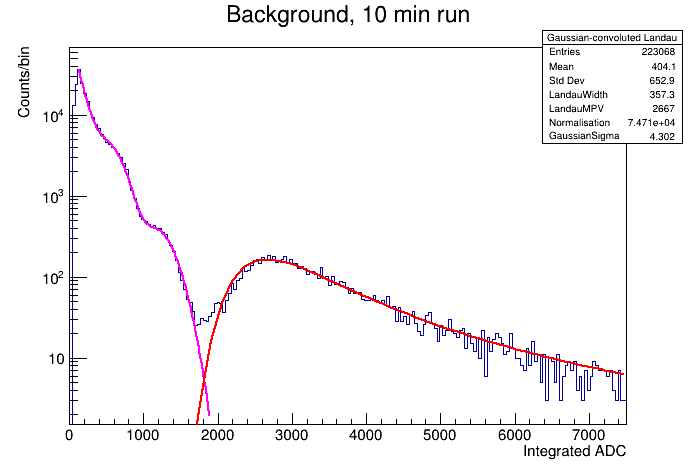

In [52]:
c3 = TCanvas( 'c3', 'Dynamic Filling Example', 200, 10, 700, 500 )
# hpx2 = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, no coincidences', 200, 100, 2000)
# #fill_hist(hpx, np.array(data['data']['low_gain'][:,1]))
# fill_hist(hpx2, np.array(data['data']['low_gain']))
hpx.Draw()

gPad.SetLogy();
# total.Draw("same")
fitResult = hpx2.GetFunction("total");
fitResult.Draw('same')
tf1.Draw("same")

c3.Draw()
# c3.SaveAs("BkgFitforDeadTime.pdf")

In [53]:
total.GetChisquare()/total.GetNDF()

10.059066898512718

### Calculate integral of function to find number of counts

#### Check that the integral of the landau-gauss func is equal to the muon flux

In [32]:
binWidth = hpx.GetBinWidth(1)
muFlux = tf1.Integral(0,7500)/(10*25*25*binWidth)
print("The muon flux is: %0.3f/cm^2/min"%muFlux)

The muon flux is: 1.263/cm^2/min


#### Gammma counts per second

In [33]:
ratePerSec = total.Integral(1900,7500)/(10*60*binWidth)

#### Gammma counts per second for the whole system

In [17]:
nMiniModperPanel = 8
nPanels = 170
rate = nMiniModperPanel*nPanels*ratePerSec

In [18]:
rate*1E-3*100

0.6424349991030764

#### Muons in that window (efficiency)

In [19]:
tf1.Integral(1900,7500)/tf1.Integral(0,7500)

0.9876056481375205

In [20]:
rate

6.424349991030764

### Plot as a function of threshold

In [21]:
muEff = []
gammaRate = []
deadTime = []
for ADC in range(1400, 2100):
    muEff.append(tf1.Integral(ADC,7500)/tf1.Integral(0,7500))
    gammaRatePerSec = total.Integral(ADC,7500)/(10*60*binWidth) #run was 10 min long and then convert to seconds
    rateGlobal = nMiniModperPanel*nPanels*gammaRatePerSec
    gammaRate.append(rateGlobal)
    deadT = rateGlobal*1E-3*100
    if(deadT>100):
        deadTime.append(100)
    else:
        deadTime.append(deadT) #Assume 1 ms risetime for light detectors
    

In [22]:
muEff = np.array(muEff)
np.where( (muEff>0.99) & (muEff<0.991) )

(array([453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
        466, 467]),)

In [23]:
muEff[467]

0.9900633078600312

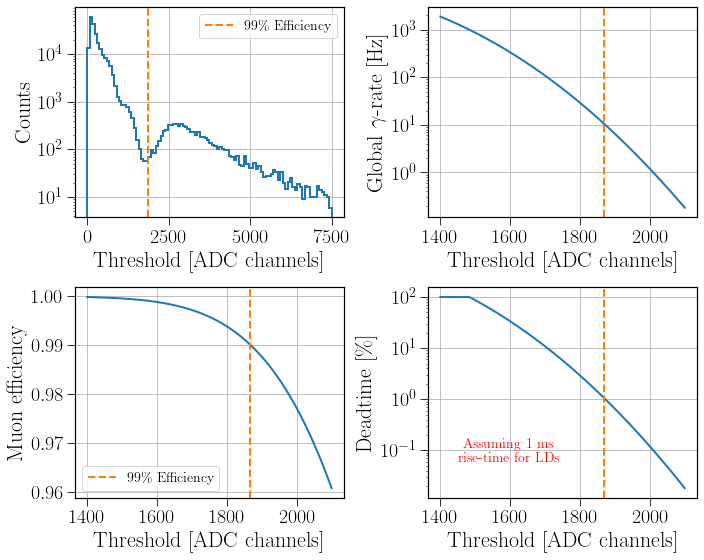

In [34]:
# fig = plt.figure(figsize=(7,8))
# gs = fig.add_gridspec(4, hspace=0)
# (ax1, ax2, ax3, ax4) = gs.subplots(sharex=True)
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2,figsize=(10,8))


ax1.hist(data['data']['low_gain'], bins=100, range=(0,7500),
         histtype='step', lw = 2);
ax1.axvline(1867, lw = 2, ls = "--", c = "C1", label = "99$\%$ Efficiency")
ax1.set_ylabel('Counts')
ax1.set_yscale('log')
ax1.set_xlabel('Threshold [ADC channels]')
ax1.grid()
ax1.legend()

ax2.plot(range(1400, 2100), np.array(muEff), lw = 2)
ax2.axvline(1867, lw = 2, ls = "--", c = "C1", label = "99$\%$ Efficiency")
ax2.set_ylabel('Muon efficiency')
ax2.set_xlabel('Threshold [ADC channels]')
ax2.grid()
ax2.legend()

ax3.plot(range(1400, 2100), np.array(gammaRate), lw = 2)
ax3.set_xlabel('Threshold [ADC channels]')
ax3.set_ylabel('Global $\gamma$-rate [Hz]')
ax3.axvline(1867, lw = 2, ls = "--", c = "C1", )
ax3.grid()
ax3.set_yscale('log')

ax4.plot(range(1400, 2100), np.array(deadTime), lw = 2)
ax4.set_xlabel('Threshold [ADC channels]')
ax4.set_ylabel('Deadtime [$\%$]')
ax4.axvline(1867, lw = 2, ls = "--", c = "C1", )
ax4.grid()
ax4.text(0.3, 0.22, 'Assuming 1 ms \n rise-time for LDs', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes, 
        color = "red")

ax4.set_yscale('log')

plt.tight_layout()
plt.savefig("multiPanel_deadtimeAndEff.pdf")